# PV power

This notebook is a tutorial in how to calculate the PV power output of a PV panel for a given location.

The notebook is hosted on Google Colab, which is an interactive computing environment that allows you to run Python Jupyter Notebooks in your browser without having to install Python.

Remember that to execute the code in a cell, click "Ctrl+Enter".

## Step 1: Install and load packages

The first step is to install and import some necessary Python packages.

Remember to execute the cells, simply click the cell and then Ctrl+Enter.

In [1]:
# Install pvlib on Google Colab, as this is not a standard package.
!pip install pvlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 25.4 MB/s eta 0:00:00


In [2]:
import pvlib  # library for PV and solar calculations
import numpy as np  # library for math and linear algebra
import pandas as pd  # library for data analysis
import matplotlib.pyplot as plt  # library for plotting

## Step 1: Define location

The first step is to define the location where your system is placed.

👉 **Action**: Update the latitude and longitude in the code below:

In [3]:
location = pvlib.location.Location(latitude=55.7874, longitude=12.5190)

## Step 2: Retrieve solar irradiance data

The next step is to retrieve solar irradiance data.

An easy way to do this is to use the [PVGIS service](https://re.jrc.ec.europa.eu/pvg_tools/en/).

The pvlib-python package has a convenient function to do this in Python, see [pvlib.iotools.get_pvgis_tmy](https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.iotools.get_pvgis_tmy.html).

Note, the retrieved dataset is a so-called Typical Meteorological Year (TMY), which has been created from historical data to represent a median year.

👉 **Action**: Plot the retrieved data. What parameters does the dataset contain?

In [8]:
data, meta = pvlib.iotools.get_pvgis_tmy(
    latitude=location.latitude,
    longitude=location.longitude,
)

# Write your code here
data

,temp_air,relative_humidity,ghi,dni,dhi,IR(h),wind_speed,wind_direction,pressure
time(UTC),,,,,,,,,
1990-01-01 00:00:00+00:00,2.65,90.76,0.0,0.0,0.0,19.83,3.61,169.0,100390.0
1990-01-01 01:00:00+00:00,2.52,90.99,0.0,0.0,0.0,21.41,3.53,164.0,100380.0
1990-01-01 02:00:00+00:00,2.39,91.22,0.0,0.0,0.0,22.99,3.44,160.0,100410.0
1990-01-01 03:00:00+00:00,2.27,91.45,0.0,0.0,0.0,24.57,3.36,150.0,100400.0
1990-01-01 04:00:00+00:00,2.14,91.68,0.0,0.0,0.0,26.15,3.28,146.0,100410.0
...,...,...,...,...,...,...,...,...,...
1990-12-31 19:00:00+00:00,3.28,89.62,0.0,0.0,0.0,11.93,4.01,188.0,100310.0
1990-12-31 20:00:00+00:00,3.15,89.85,0.0,0.0,0.0,13.51,3.93,190.0,100350.0
1990-12-31 21:00:00+00:00,3.03,90.07,0.0,0.0,0.0,15.09,3.85,187.0,100380.0


## Step 3: Calculate solar position

Similar to the first exercise, you need to calculate the solar position. In this case, we are calculating the solar position for the time steps contained in the dataset.

In [5]:
solarposition = location.get_solarposition(data.index)

solarposition.head()

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time
time(UTC),,,,,,
1990-01-01 00:00:00+00:00,146.135170,146.135170,-56.135170,-56.135170,19.558696,-3.286217
1990-01-01 01:00:00+00:00,141.807049,141.807049,-51.807049,-51.807049,41.951970,-3.306034
1990-01-01 02:00:00+00:00,135.237126,135.237126,-45.237126,-45.237126,60.355670,-3.325842
1990-01-01 03:00:00+00:00,127.430710,127.430710,-37.430710,-37.430710,75.558628,-3.345641
1990-01-01 04:00:00+00:00,119.091995,119.091995,-29.091995,-29.091995,88.734329,-3.365431


## Step 4: Calculate in-plane irradiance

The irradiance data retrieved in Step 2 contain the standard components: global horizontal irradiance (GHI), diffuse horizontal irradiance (DHI), and direct normal irradiance (DNI).

If we were to put our PV panel completely horizontal, we could simply use GHI as the incident irradiance on the panel. However, tilting PV panels can increase the incident irradiance. We therefore need to estimate the irradiance on a tilted plane using a so-called "transposition" model. Again, pvlib-python contains a convenient function for doing this, called [``get_total_irradiance``](https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.irradiance.get_total_irradiance.html).

The code cell below calculates the solar irradiance incident on a tilted plane.

👉 **Action**: update the values for the albedo and surface tilt, and azimuth based on your design.

In [9]:
# Update the surface tilt and azimuth values
surface_tilt = 40
surface_azimuth = 180
albedo = 0.2

poa_irradiance = pvlib.irradiance.get_total_irradiance(
    surface_tilt=surface_tilt,
    surface_azimuth=surface_azimuth,
    solar_zenith=solarposition['apparent_zenith'],
    solar_azimuth=solarposition['azimuth'],
    dni=data['dni'],
    ghi=data['ghi'],
    dhi=data['dhi'],
    albedo=albedo,
    model='haydavies',
    dni_extra=pvlib.irradiance.get_extra_radiation(data.index),
)

poa_irradiance.head()

,poa_global,poa_direct,poa_diffuse,poa_sky_diffuse,poa_ground_diffuse
time(UTC),,,,,
1990-01-01 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0
1990-01-01 01:00:00+00:00,0.0,0.0,0.0,0.0,0.0
1990-01-01 02:00:00+00:00,0.0,0.0,0.0,0.0,0.0
1990-01-01 03:00:00+00:00,0.0,0.0,0.0,0.0,0.0
1990-01-01 04:00:00+00:00,0.0,0.0,0.0,0.0,0.0


The DataFrame ``poa_irradiance`` contains several columns with the prefix ``poa_``. The column ``poa_global`` is the total irradiance incident on the titled surface. ``poa_global`` is the sum of ``poa_direct`` and ``poa_diffuse``.

## Step 5: Calculate module temperature

The main parameter that affects the efficiency of a PV panel is the temperature of the panel. The panel temperature increases with increasing irradiance and with increasing air temperature.

👉 **Action**: Since the code to calculate module temperature is already provided below, see if you can create a scatter plot of the module temperature vs. air temperature.

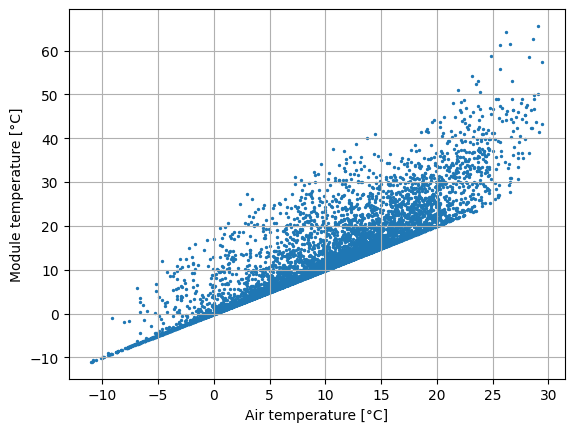

In [10]:
module_temperature = pvlib.temperature.faiman(
    poa_global=poa_irradiance['poa_global'],
    temp_air=data['temp_air'],
    wind_speed=data['wind_speed'],
    # default heat loss coefficients
    u0=25.0,
    u1=6.84)

# Write your code here to plot the module temperature as a function of air temperature
plt.scatter(data['temp_air'], module_temperature, s=2)
plt.xlabel('Air temperature [°C]')
plt.ylabel('Module temperature [°C]')
plt.grid(True)
plt.show()


## Step 6: Calculate PV power

With the plane of array irradiance and module temperature ready, we can now estimate the PV output power.

There exist different PV power models, but the simplest option is to use [pvlib.pvsystem.pvwatts_dc](https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.pvsystem.pvwatts_dc.html).  

👉 **Action**: Fill in the value of the DC power of the PV panel at STC conditions based on your findings in the previous exercise.

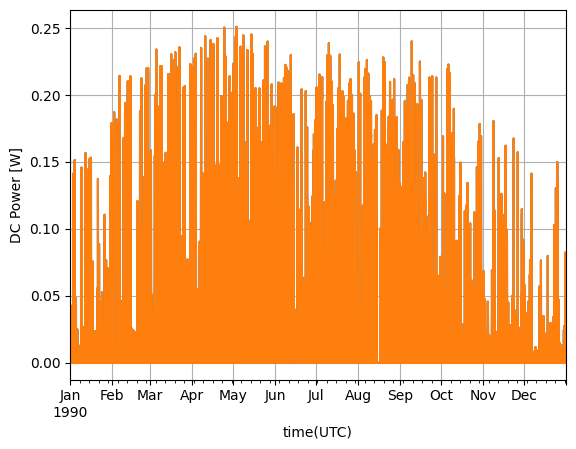

In [12]:
# Update the DC power pdc0 based on your findings in the previous exercise
pdc0 = 0.24   # W (measured max power from previous exercise)
gamma_pdc = -0.004


# Code to calculate PV power
dc_power = pvlib.pvsystem.pvwatts_dc(
    effective_irradiance=poa_irradiance['poa_global'],
    temp_cell=module_temperature,
    pdc0=pdc0,
    gamma_pdc=gamma_pdc,
    temp_ref=25.0,  # STC condition
)

dc_power.plot()
dc_power.plot()
plt.ylabel('DC Power [W]')
plt.grid(True)
plt.show()
